In [27]:
import numpy as np
import gzip
import imageio
import time
import math
import matplotlib.pyplot as plt

#Method to calculate the accuracy
def calc_accuracy(pred, actual):
    count = 0
    loss = []
    
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            count += 1
            loss.append(0)
        else:
            loss.append(1)
     
    accuracy = (1 - sum(loss)/len(pred)) * 100
    
    return accuracy

t_initial = time.time()


	 Displaying the Mean and Standard Deviation for each Digit (side-by-side) 



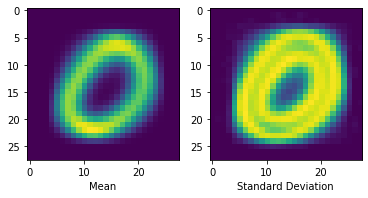

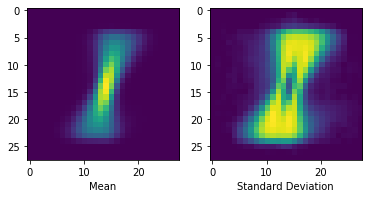

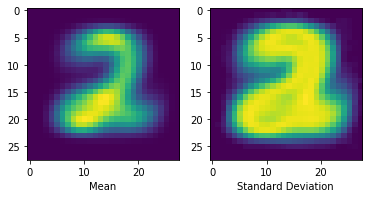

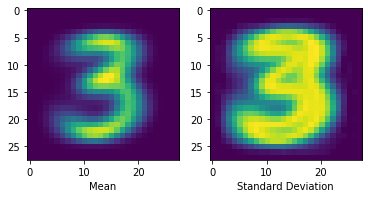

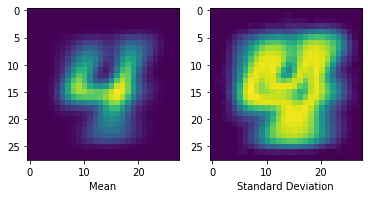

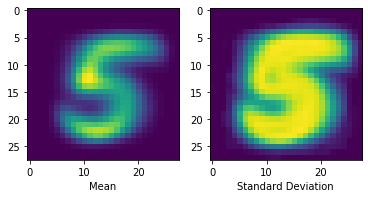

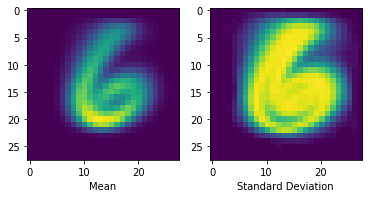

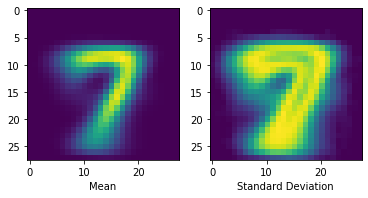

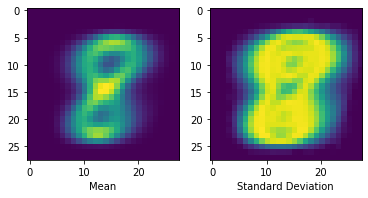

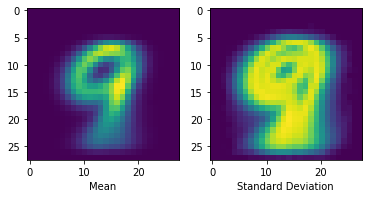

In [38]:
'''
TASK-1: Calculating the mean and standard deviation for the digit images
'''
#Reading the MNIST training images
X_train = gzip.open('train-images-idx3-ubyte.gz', 'r')
X_train.read(16)
img_dim = 28
flatten_size = img_dim*img_dim

img_count_train = 60000
buffer = X_train.read(img_dim * img_dim * img_count_train)
data = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)
data = data.reshape(img_count_train, img_dim * img_dim)

#Extracting the MNIST training labels
Y_train = gzip.open('train-labels-idx1-ubyte.gz','r')
Y_train.read(8)
buffer_labels = Y_train.read(1 * 60000)
labels = np.frombuffer(buffer_labels, dtype=np.uint8).astype(np.int64)

digits_mean = np.zeros((10, flatten_size))
count = np.zeros((10,1))
digits_stdev = np.zeros((10, flatten_size))

X = {'0':[],'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[],'8':[],'9':[]}

#Calculating the mean and the standard deviation for the digits
for index, item in enumerate(labels):
    for i in range(10):
        if item == i:
            X[str(i)].append(data[index])
            digits_mean[item] += data[index]
            count[item] += 1

#Calculating the mean value for each digit
for i in range(digits_mean.shape[0]):
    digits_mean[i] = digits_mean[i] / count[i]

#Calculating the standard deviation for each digit
for i in range(10):
    for item in X[str(i)]:
        digits_stdev[i] += (item - digits_mean[i])**2

for i in range(digits_stdev.shape[0]):
    digits_stdev[i] = np.sqrt(digits_stdev[i] / count[i])

print("=========================================================================================")
print ("\n\t Displaying the Mean and Standard Deviation for each Digit (side-by-side) \n")
print ("=========================================================================================")

#Displaying the mean and standard deviation for each digit
for i in range(10):
    display_mean = digits_mean[i].reshape(28,28,1).squeeze()
    display_stdev = np.asarray(digits_stdev[i]).reshape(28,28,1).squeeze()
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(display_mean)
    plt.xlabel("Mean")
    imageio.imwrite('img_digit_mean' + str(i) + '.png', np.asarray(display_mean, dtype = np.uint8))
    plt.subplot(1,2,2)
    plt.imshow(display_stdev)
    plt.xlabel("Standard Deviation")
    imageio.imwrite('img_digit_stdev' + str(i) + '.png', np.asarray(display_stdev, dtype = np.uint8))
    plt.show()

In [33]:
'''
TASK-2: Classifying the images in testing set using 0-1 loss function and Bayesian decision rule
'''
covariance_determinant = []
covariance_inverse = []
covariance_digits = np.zeros((10, flatten_size, flatten_size))
covariance_naive = np.zeros((10,flatten_size,flatten_size))
covariance_determinant = np.zeros((count.shape[0], 1))
covariance_inverse = np.zeros((len(count), flatten_size, flatten_size))

naive_determinant = []
naive_inverse = []
naive_determinant = np.zeros((count.shape[0], 1))
naive_inverse = np.zeros((len(count), flatten_size, flatten_size))

prior = np.zeros((10,1))
prior = count/60000

print("===========================================================================")
print("\n Calculating the Covariance Matrices, their Determinants and Inverse ... ")

#Calculating the Normal Covariance Matrix
for i in range(10):
    for image in X[str(i)]:
        temp_calc = image - digits_mean[i]
        temp_calc_transposed = np.transpose(temp_calc)
        covariance_digits[i] = covariance_digits[i] + np.dot(temp_calc_transposed, temp_calc)

#Calculating the Naive Baye's Covairance Matrix
for i in range(10):
    covariance_naive[i] += std_digits[i] * np.eye(flatten_size) 

#Calculating the Determinant and Inverse of the two matrices
for i in range(count.shape[0]):
    covariance_digits[i] = np.divide(covariance_digits[i], (count[i] - 1)) + 0.9 * np.eye(784)
    sign, determinant = np.linalg.slogdet(covariance_digits[i])
    act_det = sign * np.exp(determinant)
    covariance_determinant[i] = act_det
    inverse = np.linalg.inv(covariance_digits[i])
    covariance_inverse[i] = inverse
    
    covariance_naive[i] += 0.9 * np.eye(flatten_size)
    sign_naive, determinant_naive = np.linalg.slogdet(covariance_naive[i])
    act_det_naive = sign_naive * np.exp(determinant_naive)
    naive_determinant[i] = act_det_naive
    inverse_naive = np.linalg.inv(covariance_naive[i])
    naive_inverse[i] = inverse_naive

print(" Covariance Matrix, Determinant and Inverse calculated \n")
print("===========================================================================")

#Reading the MNIST test data features  
X_test = gzip.open('t10k-images-idx3-ubyte.gz', 'r')
X_test.read(16)
img_count_test = 10000
buffer_test = X_test.read(img_dim * img_dim * img_count_test)
data_test = np.frombuffer(buffer_test, dtype=np.uint8).astype(np.float32)
data_test = data_test.reshape(img_count_test, img_dim * img_dim)

#Extracting the MNIST test data labels
Y_test = gzip.open('t10k-labels-idx1-ubyte.gz','r')
Y_test.read(8)
buffer_test_labels = Y_test.read(1 * 10000)
test_labels = np.frombuffer(buffer_test_labels, dtype=np.uint8).astype(np.int64)

D = flatten_size
test_predict = []
naive_test_predict = []

#Performing the classification using Bayes Decision Rule and Naive Bayes
for index in range(len(test_labels)):
    likelihood = []
    likelihood_naive = []
    
    for i in range(10):
        '''
        Reshaping the test image feature matrix to 1 x flatten_size after raveling
        as the dimensions of the data_test[index].ravel() = flatten_size x 1
        '''
        temp = data_test[index] - digits_mean[i]
      
        #Using np.dot is imperative as normal multiplication does element wise multiplication which degrades performance
        temp_calc = np.dot(np.dot(temp, cov_inverse[i]), np.transpose(temp))
        n_temp_calc = np.dot(np.dot(temp, naive_inverse[i]), np.transpose(temp))
        
        log_likelihood = - ( D*0.5 )*np.log( 2*math.pi ) - 0.5*cov_determinant[i] - 0.5*temp_calc
        log_likelihood_naive = - ( D*0.5 )*np.log( 2*math.pi ) - 0.5*np.log(naive_determinant[i]) - 0.5*n_temp_calc
        
        #Adding the P(c) values to every column (for each class) of the likelihood
        p_c = log_likelihood + np.log(prior[i])
        naive_p_c = log_likelihood_naive + np.log(prior[i])
        likelihood.append(p_c)
        likelihood_naive.append(naive_p_c)
        
    predicted_class = np.argmax(likelihood)
    test_predict.append(predicted_class)
    naive_predicted_class = np.argmax(likelihood_naive)
    naive_test_predict.append(naive_predicted_class)

#Calculating the accuracy for Bayes Decision Rule and Naive Bayes, and reporting the performance
accuracy = calc_accuracy(test_predict, test_labels)
naive_accuracy = calc_accuracy(naive_test_predict, test_labels)
print ("\n Bayes Decision Rule Accuracy: ", accuracy)
print(" Naive Bayes Accuracy:", naive_accuracy)
print("\n===========================================================================")
print(" Time taken for calculating O-1 Loss Function:", time.time() - t_initial)
print("===========================================================================")


 Calculating the Covariance Matrices, their Determinants and Inverse ... 
 Covariance Matrix, Determinant and Inverse calculated 


 Bayes Decision Rule Accuracy:  82.49
 Naive Bayes Accuracy: 9.799999999999997

 Time taken for calculating O-1 Loss Function: 1539.286013841629



 	 Displaying Fisher Digits 



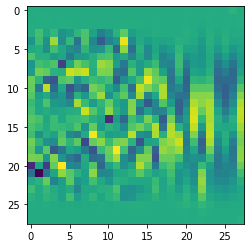

In [37]:
'''
TASK-3: Constructing the "Fisher digits" from the MNIST data set 
'''    
Sw = np.zeros((img_dim, img_dim))
Sb = np.zeros((img_dim, img_dim))
Mu = np.mean(digits_mean, axis=0)

for i in range(10):
    Sum = 0
    
    for j in range(len(count[i])):
        difference = X[str(i)][j].reshape(img_dim, img_dim) - digits_mean[i].reshape(img_dim, img_dim)
        Sum += np.dot(np.transpose(difference),difference)
        
    Sw += Sum
    
    #Calculating the between-class scatter matrix to compute the between class differences
    mean_diff = digits_mean[i].reshape(img_dim, img_dim) - Mu.reshape(img_dim, img_dim)
    Sb += np.dot(np.transpose(mean_diff), mean_diff)

eigen_vectors = []
eigen_values = []
Sb_inverse = []

Sb_inverse = np.zeros((img_dim, img_dim))
Sb += 0.8*np.eye(img_dim)     
Sb_inverse = np.linalg.inv(Sb)
class_diff = np.dot(Sw, Sb_inverse)
Lambda, V = np.linalg.eig(class_diff)

eigen_vectors.append(V)
eigen_values.append(Lambda)
nonzero_eigen = np.nonzero(Lambda)[0]
lambda_reshaped = Lambda.reshape(1,len(Lambda))
Lambda = Lambda*np.eye(img_dim)

#Displaying the Fisher Digits
print("===============================================")
print("\n \t Displaying Fisher Digits \n")
print("===============================================")
plt.figure()
image = np.asarray(V)
plt.imshow(image)
plt.show()